In [58]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import datetime as dt

In [59]:

# Step 1: Data Collection

# Load historical data for EUR/USD, GBP/USD, 10Y and 30Y Treasury
eur_usd = yf.download('EURUSD=X', start='2010-01-01', end='2023-12-31')['Close']
gbp_usd = yf.download('GBPUSD=X', start='2010-01-01', end='2023-12-31')['Close']
treasury_10y = yf.download('^TNX', start='2010-01-01', end='2023-12-31')['Close']
treasury_30y = yf.download('^TYX', start='2010-01-01', end='2023-12-31')['Close']

# Calculate the 10Y-30Y yield spread
yield_spread = treasury_10y - treasury_30y

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'EUR/USD': eur_usd,
    'GBP/USD': gbp_usd,
    '10Y Treasury': treasury_10y,
    '30Y Treasury': treasury_30y,
    '10Y-30Y Spread': yield_spread
})

# Drop any rows with missing values
data.dropna(inplace=True)

# Step 2: Data Preprocessing

# Create lagged features (e.g., use past 3 days' data to predict the next day)
lags = 3
for col in data.columns:
    for lag in range(1, lags + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

# Drop rows with missing values due to lagging
data.dropna(inplace=True)

# Define features and target variable
X = data  # Features (all columns except USD/JPY)
y = yf.download('JPY=X', start='2010-01-01', end='2023-12-31')['Close']  # Target (USD/JPY)

# Align y with the lagged X data
y = y.iloc[lags:]  # Adjust for the number of lags

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Normalize the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalize the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape the features for LSTM (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Step 3: Model Definition

def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=25))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [60]:

# Step 4: Hyperparameter Tuning

# Wrap the model with KerasRegressor from SciKeras
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

In [61]:

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Print the best parameters and best score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {-grid_result.best_score_}")  # Convert negative MSE to positive for interpretation

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters: {'batch_size': 64, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__units': 50, 'optimizer': 'rmsprop'}
Best Score: 8.427903550938828


In [62]:

# Step 5: Evaluate the Model and Make Predictions

# Retrieve the best model
best_model = grid_result.best_estimator_

# Predict using the best model
train_predict_scaled = best_model.predict(X_train_scaled)
test_predict_scaled = best_model.predict(X_test_scaled)

# Inverse transform the predictions to get actual values
train_predict = scaler_y.inverse_transform(train_predict_scaled.reshape(-1, 1)).flatten()
test_predict = scaler_y.inverse_transform(test_predict_scaled.reshape(-1, 1)).flatten()

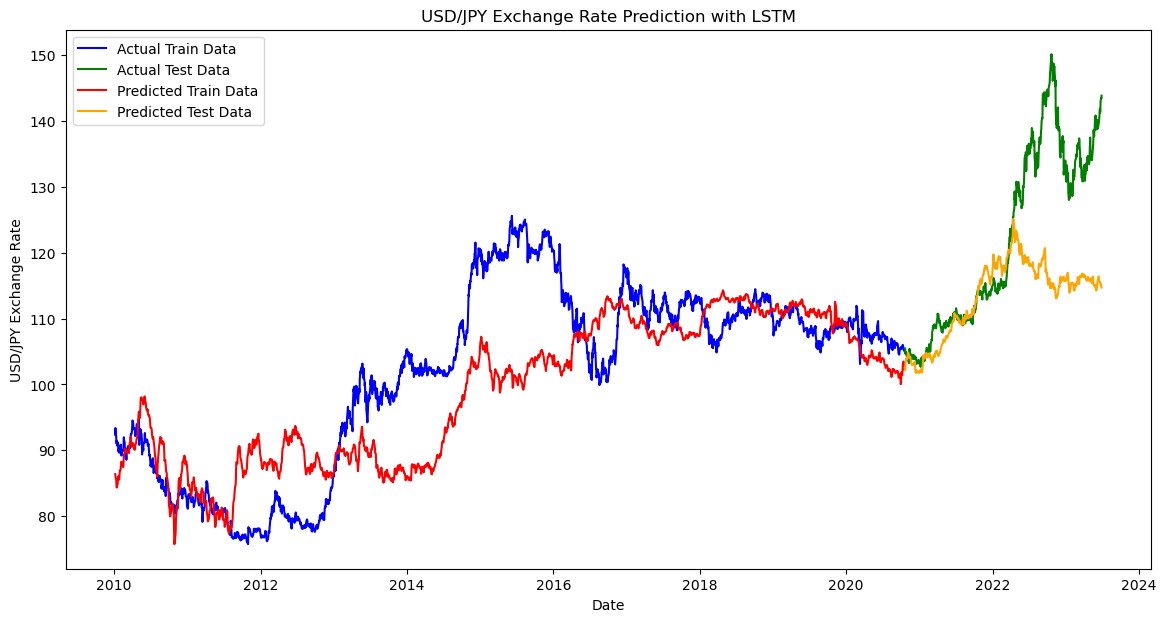

In [84]:
# Plot the predictions
# Ensure the lengths of y and predictions match
if len(y_train) != len(train_predict):
    min_length_train = min(len(y_train), len(train_predict))
    y_train = y_train.iloc[:min_length_train]
    train_predict = train_predict[:min_length_train]

if len(y_test) != len(test_predict):
    min_length_test = min(len(y_test), len(test_predict))
    y_test = y_test.iloc[:min_length_test]
    test_predict = test_predict[:min_length_test]

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')
plt.plot(y_train.index, train_predict, label='Predicted Train Data', color='red')
plt.plot(y_test.index, test_predict, label='Predicted Test Data', color='orange')
plt.title('USD/JPY Exchange Rate Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()

In [87]:
# Predict for start of 2024 to today

# Define the number of days to predict
days_to_predict = (dt.datetime.now() - dt.datetime(2024, 1, 1)).days

# Create a copy of the data to store the predictions
data_pred = data.copy()

# Predict the USD/JPY exchange rate for each day

for day in range(1, days_to_predict + 1):
    # Create lagged features for the current day
    for col in data.columns:
        for lag in range(1, lags + 1):
            data_pred.loc[dt.datetime(2024, 1, 1) + dt.timedelta(days=day), f'{col}_lag{lag}'] = data_pred[col].iloc[-lag]

    # Normalize the features
    X_pred_scaled = scaler_X.transform(data_pred.iloc[-1].values.reshape(1, -1))
    X_pred_scaled = X_pred_scaled.reshape(1, X_pred_scaled.shape[1], 1)

    # Predict the USD/JPY exchange rate for the current day
    y_pred_scaled = best_model.predict(X_pred_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Update the data with the predicted USD/JPY exchange rate
    data_pred.loc[dt.datetime(2024, 1, 1) + dt.timedelta(days=day), 'JPY=X'] = y_pred[0]
    
# Plot the predicted USD/JPY exchange rate
plt.figure(figsize=(14, 7))
plt.plot(data['JPY=X'], label='Historical Data', color='blue')
plt.plot(data_pred['JPY=X'], label='Predicted Data', color='red')
plt.title('USD/JPY Exchange Rate Prediction for 2024')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')

plt.legend()
plt.show()


D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: X has 65 features, but MinMaxScaler is expecting 20 features as input.